In [ ]:
from os.path import isfile, join
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize,word_tokenize
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
import re

import operator
#!pip install python-docx
import docx

[nltk_data] Downloading package punkt to /home/hamdy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#!pip install docx2txt
#import docx2txt
#foldername = "/media/sf_D_DRIVE/Arabic/Education/ArabicBooks/Hamdy-MergedFiles/"
#filename = foldername + "All-G2-Gulf files.docx"
#text = docx2txt.process(filename)

In [ ]:
def read_docx(filename):
    doc = docx.Document(filename)
    full_text = []
    for para in doc.paragraphs:
        full_text.append(para.text)
    #return '\n'.join(fullText)
    return full_text

# Some important functions

In [ ]:
def removePunctuation(text):
    result = ""

    for char in text:
        if char in (".",",","!","?","؟","،","\",""/","\"","#","$","%","&","'","(",")","*","+",":",";","<",">","=","[","]","^","_","`","{","}","|","~"):
            continue
        if char in ("-","\n","\r","\t"):
            char=" "
        if(char.isdigit()):
            continue    
        result+=char
    #result = re.sub('[ًٌٍَُِّْـ]+', '', result)    
    return result


def remove_diac(text):
    result = re.sub('[ًٌٍَُِّْـ]+', '', text)
    return result


def characterCount(text):
    text = remove_diac(text)
    count=0
    #text=removePunctuation(text)
    for char in text:
        #Hamdy if (char.isdigit() or char.isspace()):
        if (char.isspace()):
            continue;
        count+=1
    #print("Character Count is ",count)
    return count


def wordCount(text):
    count=0
    words=word_tokenize(text)
    #print(words)
    for i in words:
        #hamdy: if(i.isdigit()):
        #Hamdy    continue;
        count+=1
    #print("Word Count is ",count)
    
    #Hamdy
    if count == 0:
        count = 1 # if input = "4 " -> method gives division by zero!
    return count


def sentenceCount(text):
    sentence=sent_tokenize(text)
    #print(sentence)
    count=len(sentence)
    #print("Sentence Count is ",count)
    return count

def paragraphCount(text):
    count=  [line.strip() for line in text.split('\n') if len(line.strip()) > 0]
    #print("Paragraph Count is",len(count))
    return len(count)

def ar_syllables(word):
    #fatha, damma, kasra
    tashkeel = ['\u064E','\u064F','\u0650']

    count_long = 0
    count_short = 0
    count_stress = 0

    for x in range(0,len(tashkeel)):
        for i in range(0, len(word)):
            if word[i] == tashkeel[x]:
                if i+1 < len(word):
                    #to count long syllables we need to check if the character following is an alef, waw or yaaA.
                    if word[i+1]=='\u0627' or word[i+1]=='\u0648' or word[i+1]=='\u064a':
                        count_long += 1
                    else:
                        count_short += 1
                else:
                    count_short += 1

    #counts stress syllables, those tanween fatih, tanween damm, tanween kasr and shadda.
    count_stress = word.count("\u064B") + word.count("\u064C") + word.count("\u064D") + word.count("\u0651")
    #syllables_count = count_short + (2 * count_long) + (2 * count_stress)
    #syllables_count = 1 + (2 * count_long) + (2 * count_stress)
    syllables_count = count_short + (1 * count_long) + (1 * count_stress)
    # complex syllables
    #syllables_count = 0
    #if count_short > 4 or count_stress >=2 or count_long >= 2:
    #    syllables_count = 1
    return syllables_count

def ar_syllables_count(text):
  words = text.split(" ")
  count = 0
  for i in words:
    count = count+ar_syllables(i)
  return count 




# Characters Per Word
def CPW(text):
    WordCount=wordCount(text)
    CharacterCount=characterCount(text)
    CharactersPerWord=round(CharacterCount/WordCount,2)
    return CharactersPerWord

#Words Per Sentence
def WPS(text):
    WordCount=wordCount(text)
    SentenceCount=sentenceCount(text)
    WordsPerSentence=round(WordCount/SentenceCount,2)
    return WordsPerSentence

#sentence per pragraph
def SPP(text):
    Sentence = sentenceCount(text)
    pragragh = paragraphCount(text)
    SentencePerPragragh = round(Sentence/pragragh,2)
    return SentencePerPragragh

# average syllable
def get_all_features(text):
    #chars = characterCount(text)
    #words = wordCount(text)
    #sentences = sentenceCount(text)
    wordpsetntence = WPS(text)
    charpword = CPW(text)
    sentppragraph = SPP(text)
    syllables= round(ar_syllables_count(text) / wordCount(text), 2)
    #syllables= round(ar_syllables_count(text), 2)
    #return float(chars),float(words),float(sentences),float(charpword),float(wordpsetntence)
    
    return charpword,wordpsetntence, sentppragraph , syllables


In [ ]:
def is_arabic(w):
    arb = True
    for ch in w:
        if (ch < 'ء' or ch > 'ي'):
            arb = False
            break
    
    return arb

def get_top(dic, N, label):
    s = label + "\n"
    i = 0
    for name, freq in dic.items():
        s += "%s\t%d\n" % (name, freq)

        i += 1
        if i == N:
            break
    return s

In [ ]:
import operator
foldername = "/media/sf_D_DRIVE/Arabic/Education/ArabicBooks/Hamdy-MergedFiles/"
filename_out = "stats.txt"
fh_out = open(foldername + filename_out, "wt", encoding="utf-8")

word_freq = {}
for g in range(1,7):
    filename = "%s/All-G%d-Gulf files.docx" % (foldername, g)
    text_docx = read_docx(filename)
    
    for i, line in enumerate(text_docx):
        
        if i % 1000 == 0:
            print(g, i, line)
        line2 = remove_diac(line)
        
        #if i == 1000:
        #    break

        words = word_tokenize(line2)
        for w in words:
            if not is_arabic(w) or len(w) == 1:
                continue
            if not w in word_freq:
                word_freq[w] = 0
            word_freq[w] += 1

word_freq2 = dict(sorted(word_freq.items(), key=operator.itemgetter(1),reverse=True))
top_words = get_top(word_freq2, 100000, "most frequent words")
fh_out.write(top_words)
fh_out.close()
#print(top_words)

1 0 حروف لغتي
1 1000 ـو			جَـ.......اد
1 2000 ب- 	تَعالَ	تَعالَيْ
1 3000 باب		تَمْر 		تُفّاح 		بِنْت 		كَتءكوت		حِبْر
1 4000 
1 5000 

1 6000 

1 7000 أُعيدٌ ترتيبَ الْكَلِمَاتِ الآتِيَةِ لِأحْصُلَ على جُمْلَةٍ مُفِيدَةٍ :
1 8000 العربية  لغتنا
1 9000 
1 10000 
1 11000 
1 12000 قالَتْ   سامِحْهُ مِنْ أَجْلي .
1 13000 تَلْبَسُ				يَلْبَسُ
1 14000 
1 15000 

1 16000 ـظَ 		ـظُ 		ـظِ 		ـظْ
1 17000 أُحَوِّطُ الْحَرْفَ أو الْمقْطَعَ الَّذي أَعْرِفُهُ ثم أَقْرَؤه:
1 18000 أًنا صادِقٌ
1 19000 أَحَلِّلُ الكَلِماتِ شَفَوِيًّا، ثُمَّ أَكْتُبُ:
1 20000 -1 ماذا تُشاهِدُ في اللَّوْحَةِ؟		 -2 ماذا يوجَدُ في الْمَزْرِعَةِ؟
1 21000 أُفَكِّرُ، وَأُبْدِعُ
1 22000 المْجَلْسِ 
1 23000 9  أَسْتَمِعُ وَأُحَاكِي عُمَرَ فِي نُطْقِ الْمَقْطَعِ السَّاكِنِ :
1 24000 
1 25000 
1 26000 ج
2 0 
2 1000 
2 2000 أُعيدُ كِتابَةَ الْفِقْرَةِ الْآتِيَةِ مُسْتَعْمِلاً(مُحَمَّد) بَدَلَ هُدى:
2 3000 حُسامٌ وَ نسيمٌ وَ سَيْفٌ أَصْدِقاُء .
2 4000 الدَّرس 3
2 5000 أَقْرَأُ 
2 6000 ثالثاً: أُحَوِّلُ 
2 7000 جِذْعِي 
2 8000 التَّر

6 27000 مَعَ والديَّ
6 28000 وكانَ لنا جَدّةٌ طيّبةُ القلبِ تزورُنا من حِينٍ إلى آخرَ، وتَبيتُ عِنْدَنا، فنفْرَحُ بِلقائها وحُسْنِ حَديثِها. وكانتْ تعْرِفُ من القِصصِ الشَّعبيّةِ الشّيءَ الكثيرَ الذّي لا يفرَغُ، فنتحلّقُ حوْلَها، ونسمعُ حِكاياتِها حتّى يَغْلِبَنا النّومُ. وهي قِصَصٌ مُفرِحةٌ حينًا، مُرعِبَةٌ حينًا آخرَ... وتتخلّلُ هذهِ القِصَصَ الأمثالُ الشَّعبيّةُ اللَّطيفةُ والجُمَلُ التّي يتركّزُ فيها مَغْزى القِصّةِ.
6 29000 مِنْ مَكارِمِ الأَخْلاقِ
6 30000  (........) بِرْكَةُ الماءِ تَفوقُ البَحْرَ جَمالً وَرَوْنَقًا.
6 31000 وَالرَّوْضُ فيهِ اخْتيِالْ


In [ ]:
MAX_WORDS_FREQ = 10000
top_word_freq = {}
cnt = 0
for w, freq in word_freq2.items():
    top_word_freq[w] = freq
    
    cnt += 1
    if cnt == MAX_WORDS_FREQ:
        break

In [ ]:
text = "بسم الله. الحمد لله رب العالمين! اهلا بكم؟ هنا"
print(sentenceCount(text))
print(get_all_features(text))

3
(3.45, 3.67, 3.0, 0.0)


In [ ]:
print(get_all_features("النَّخْلَةُ هِيَ مَعَ"))

(3.33, 3.0, 1.0, 2.67)


In [ ]:
def complex_words(text):
    ncomplex = 0
    words = text.split(" ")
    
    for w in words:        
        #w2 = w.replace("ال+", "")
        #w2 = w2.replace("+", "")
        #if len(w2) > 6:
            #print(w2)
            #ncomplex += 1
        seg = w.split("+")
        cnt = 0
        for s in seg:
            #if s == "ال" or s == "ة" or s == "و":# or s == "ب" or s == "ل":
            #    continue
            cnt += 1
            if cnt == 3 or len(s) >= 6:
                ncomplex += 1
                break
    
    return ncomplex

def complex_words2(text):
    text2 = remove_diac(text)
    words = word_tokenize(text2)
    ncomplex = 0
    
    for w in words:        
        if not w in top_word_freq:
            #print("complex word, not common:", w)
            ncomplex += 1
    
    ncomplex = round(ncomplex / len(words), 2)
    return ncomplex

In [ ]:
line = "أقرأ و+أتعلم . ب+مدرس+ت+نا ال+حضار+ة"
print(complex_words(line))
print(complex_words("ب+ال+كبريت"))
print(complex_words2("بسم الله الرحمن الرحيم وبه نستعين"))

2
1
0.17


In [ ]:
LM = {}
# load aljazeera LM
fh = open("/media/sf_D_DRIVE/PERL/raw-aljazeera-text.nonorm.lm", encoding="utf-8")
for line in fh:
    fields = line.split("\t")
    if len(fields) != 2:
        continue
    word = fields[0]
    freq = fields[1]
    LM[word] = int(freq)

cnt = 0
for key, value in LM.items():
    print(key, value)
    cnt += 1
    if cnt == 10:
        break

Total_Terms 105758207
في 3671564
من 2330186
أن 1534168
على 1520368
إلى 1103242
عن 641711
التي 597724
إن 463476
مع 460636


In [ ]:
def LM_complex_words(text):
    ncomplex = 0
    text = remove_diac(text)
    words = word_tokenize(text)
    #print(words)
    for w in words:
        if w in LM:
            freq = LM[w]
            if freq < 20:
                ncomplex += 1
                #print(w, freq)
        else:
            ncomplex += 1
            #print(w)
    return ncomplex / len(words)

In [ ]:
print(LM_complex_words("ذَهَبَ الولد إلى حديقته الغناء وبستاننا الكبيرين"))

0.14285714285714285


# Read Data

In [ ]:
sample_files = True
grade1 = grade2 = grade3 = grade4 = grade5 = grade6 = []
if sample_files:

    
    data_folder = "/media/sf_D_DRIVE/QCRI/Internship2020/"
    grade1path = data_folder + "Qatar1-sample100.txt.diac"
    grade2path = data_folder + "Qatar2-sample100.txt.diac"
    grade3path = data_folder + "Qatar3-sample100.txt.diac"
    grade4path = data_folder + "Qatar4-sample100.txt.diac"
    grade5path = data_folder + "Qatar5-sample100.txt.diac"
    grade6path = data_folder + "Qatar6-sample100.txt.diac"

    grade1 = [l for l in open(grade1path,encoding='utf-8').readlines() if isfile(grade1path)]
    grade2 = [l for l in open(grade2path,encoding='utf-8').readlines() if isfile(grade2path)]
    grade3 = [l for l in open(grade3path,encoding='utf-8').readlines() if isfile(grade3path)]
    grade4 = [l for l in open(grade4path,encoding='utf-8').readlines() if isfile(grade4path)]
    grade5 = [l for l in open(grade5path,encoding='utf-8').readlines() if isfile(grade5path)]
    grade6 = [l for l in open(grade6path,encoding='utf-8').readlines() if isfile(grade6path)]    
    
    # load farasa segmentation
    grade1path = data_folder + "Qatar1-sample100-seg.txt"
    grade2path = data_folder + "Qatar2-sample100-seg.txt"
    grade3path = data_folder + "Qatar3-sample100-seg.txt"
    grade4path = data_folder + "Qatar4-sample100-seg.txt"
    grade5path = data_folder + "Qatar5-sample100-seg.txt"
    grade6path = data_folder + "Qatar6-sample100-seg.txt"

    seg1 = [l for l in open(grade1path,encoding='utf-8').readlines() if isfile(grade1path)]
    seg2 = [l for l in open(grade2path,encoding='utf-8').readlines() if isfile(grade2path)]
    seg3 = [l for l in open(grade3path,encoding='utf-8').readlines() if isfile(grade3path)]
    seg4 = [l for l in open(grade4path,encoding='utf-8').readlines() if isfile(grade4path)]
    seg5 = [l for l in open(grade5path,encoding='utf-8').readlines() if isfile(grade5path)]
    seg6 = [l for l in open(grade6path,encoding='utf-8').readlines() if isfile(grade6path)]    
        
    # load farasa POS
    grade1path = data_folder + "Qatar1-sample100.txt.pos"
    grade2path = data_folder + "Qatar2-sample100.txt.pos"
    grade3path = data_folder + "Qatar3-sample100.txt.pos"
    grade4path = data_folder + "Qatar4-sample100.txt.pos"
    grade5path = data_folder + "Qatar5-sample100.txt.pos"
    grade6path = data_folder + "Qatar6-sample100.txt.pos"

    pos1 = [l for l in open(grade1path,encoding='utf-8').readlines() if isfile(grade1path)]
    pos2 = [l for l in open(grade2path,encoding='utf-8').readlines() if isfile(grade2path)]
    pos3 = [l for l in open(grade3path,encoding='utf-8').readlines() if isfile(grade3path)]
    pos4 = [l for l in open(grade4path,encoding='utf-8').readlines() if isfile(grade4path)]
    pos5 = [l for l in open(grade5path,encoding='utf-8').readlines() if isfile(grade5path)]
    pos6 = [l for l in open(grade6path,encoding='utf-8').readlines() if isfile(grade6path)]    

else:
    data_folder = "/media/sf_D_DRIVE/Arabic/Education/ArabicBooks/Qatar/"
    grade1path = data_folder + "QA1-Term1-2.txt"
    grade2path = data_folder + "QA2-Term1-2.txt"
    grade3path = data_folder + "QA3-Term1-2.txt"
    grade4path = data_folder + "QA4-Term1-2.txt"
    grade5path = data_folder + "QA5-Term1-2.txt"
    grade6path = data_folder + "QA6-Term1-2.txt"
    
    # remove empty lines
    filename = "%s/QA1-Term1-2.txt" % (data_folder)
    fh = open(filename, "rt", encoding="utf-8")
    for line in fh:
        line = line.strip()
        if len(line) > 0:
            grade1.append(line)
    fh.close()

    filename = "%s/QA2-Term1-2.txt" % (data_folder)
    fh = open(filename, "rt", encoding="utf-8")
    for line in fh:
        line = line.strip()
        if len(line) > 0:
            grade2.append(line)
    fh.close()

    filename = "%s/QA3-Term1-2.txt" % (data_folder)
    fh = open(filename, "rt", encoding="utf-8")
    for line in fh:
        line = line.strip()
        if len(line) > 0:
            grade3.append(line)
    fh.close()

    filename = "%s/QA4-Term1-2.txt" % (data_folder)
    fh = open(filename, "rt", encoding="utf-8")
    for line in fh:
        line = line.strip()
        if len(line) > 0:
            grade4.append(line)
    fh.close()

    filename = "%s/QA5-Term1-2.txt" % (data_folder)
    fh = open(filename, "rt", encoding="utf-8")
    for line in fh:
        line = line.strip()
        if len(line) > 0:
            grade5.append(line)
    fh.close()

    filename = "%s/QA6-Term1-2.txt" % (data_folder)
    fh = open(filename, "rt", encoding="utf-8")
    for line in fh:
        line = line.strip()
        if len(line) > 0:
            grade6.append(line)
    fh.close()

# Print some examples from data


In [ ]:
lines1 = len(grade1)
lines2 = len(grade2)
lines3 = len(grade3)
lines4 = len(grade4)
lines5 = len(grade5)
lines6 = len(grade6)

print("grade1:", grade1[0], lines1)
print("grade2:", grade2[0], lines2)
print("grade3:", grade3[0], lines3)
print("grade4:", grade4[0], lines4)
print("grade5:", grade5[0], lines5)
print("grade6:", grade6[0], lines6)

grade1: أَقْرَأُ وَأَفْهَمُ :
 100
grade2: كَانَ حَمَدٌ يَسِيرُ مَعَ أَخِيه وَوَالِدِهِ
 100
grade3: الْحَدِيثُ الشَّرِيفُ
 100
grade4: يَنْهَانَا اللَّهُ ( عَزَّ وَجَلَّ ) فِي هَذِهِ الْآيَاتِ عَنْ بَعْضِ الْعَادَاتِ السَّيِّئَةِ اَلَّتِي يَقُومُ بِهَا بَعْضُ النَّاسِ ، مِثْلُ : السُّخْرِيَةِ ، وَاَلْتَّنابُزِ بِالْأَلْقَابِ ، كَمَا يُحَذِّرُنا مِنْ الظَّنِّ السَّيِّئِ بِالْآخَرِينَ ، وَيُعْرَفُنا أَنْ تَقْوَى الْإِنْسَانُ هِيَ وَحْدَهَا أَسَاسَ التَّكْرِيمِ عِنْدَ اللَّهِ ( عَزَّ وَجَلَّ ) .
 100
grade5: قَالَ تَعَالَى : ( أَلَمْ تَرَ إِلَى اَلَّذِي حَآجَ إِبْرَاهِيمَ فِي رَبِّهِ أَنْ آتَاه اللَّهُ الْمَلِكَ إِذْ قَالَ إِبْرَاهِيمُ رَبِّي اَلَّذِي يُحْيي وَيُمِيتُ قَالَ أَنَا أَحْيَي وَأُمِيُتَ قَالَ إِبْرَاهِيمُ فَإِنَّ اللَّهَ يَأْتي بِالشَّمْسِ مِنْ الْمَشْرِقِ فَأُتِ بِهَا مِنْ الْمَغْرِبِ فَبُهِتَ اَلَّذِي كُفْرَ واللَّهُ لَا يَهْدي الْقَوْمَ الظَّالِمِينَ ( 258 ) ) . [ الْبَقَرَةِ : 258 ] .
 100
grade6: اسْتَبْعَدَ الْكَلِمَةَ الْغَرِيبَةَ عَنْ أُسْرَةِ الْكَلِمَاتِ الاَّتيَةِ 

In [ ]:
print(grade1[0:21])

['أَقْرَأُ وَأَفْهَمُ :\n', 'النَّخْلَةُ\n', 'النَّخْلَةُ أَمِيرَةُ الصَّحْرَاءِ ، وَرَمْزُ الْخَيْرِ وَالْعَطَاءِ ، وَهِيَ مَوْجُودَةٌ بِكَثْرَةٍ فِي بِلَادِنَا .\n', 'لِلنَّخْلَةِ سَاقٌ طَوِيلَةٌ ، وَسَعَفَ يَمْنَحُنَا الظِّلَّ .\n', 'تُثْمِرُ النَّخْلَةُ التَّمْرُ ، وَهُوَ طَعَامٌ لَذِيذٌ وَمُفِيدٌ جِدًّا .\n', 'اسْتَيْقَظَ حَسَّانُ مُبَكِّرًا ، وَرَأَى الشَّمْسُ سَاطِعَةً .\n', 'شَاهَدْتْ الْعُصْفُورَ يَبْني الْعُشَّ فَوْقَ الشَّجَرَةِ .\n', 'صَادَّ اَلْقَنّاصُ عُصْفُورًا ، وَحَبْسَهُ فِي اَلْقَفَصِ .\n', 'أَنَا أُساعِدُ أُمِّي ، وَأَضَعُ الْبِيضَ عَلِيَّ اَلْمِنْضَدَةِ .\n', 'يَصُومُ سَعْدُ شَهْرِ رَمَضَانَ الْمُبَارَكِ .\n', 'بِنَظَافَةِ الْأَوْطَانِ تَعْلو مَكَانَةً\n', 'فِي الْبُسْتَانِ فِي الْبُسْتَانِ\n', 'أَضْحَكُ أَلْعَبُ فِي الْبُسْتَانِ\n', 'شقشَّقُ عُصْفُورٌ رِنانْ\n', 'أَرْكُضُ أَمْرَحُ أَزْهو أَفْرَحَ\n', 'أَزْرَعُ مَجْدًا أَكْتُبُ عَهْدًا\n', 'فِي طَاعَةِ رَبِّي الرَّحْمَنِ\n', 'كَمْ فَصْلًا فِي السُّنَّةِ ؟\n', 'اُكْتُبْ تَحْتَ كُلِّ صُورَةٍ مِمَّا يَأْتي اسْمُ الْفَ

# process data

In [ ]:
train_size1 = int(round(lines1 * 0.8))
train_size2 = int(round(lines2 * 0.8))
train_size3 = int(round(lines3 * 0.8))
train_size4 = int(round(lines4 * 0.8))
train_size5 = int(round(lines5 * 0.8))
train_size6 = int(round(lines6 * 0.8))

X_train_1 = grade1[0:train_size1]+grade2[0:train_size2]+grade3[0:train_size3]+grade4[0:train_size4]+grade5[0:train_size5]+grade6[0:train_size6]
seg_train_1 = seg1[0:train_size1]+seg2[0:train_size2]+seg3[0:train_size3]+seg4[0:train_size4]+seg5[0:train_size5]+seg6[0:train_size6]
pos_train_1 = pos1[0:train_size1]+pos2[0:train_size2]+pos3[0:train_size3]+pos4[0:train_size4]+pos5[0:train_size5]+pos6[0:train_size6]

In [ ]:
#output_labels = [1,2,3,4,5,6]
output_labels = [1,1,2,2,3,3] # if we wan to merge some grades together
Y_train =[]
for i in range(train_size1):
    Y_train.append(output_labels[0])

for i in range(train_size2):
    Y_train.append(output_labels[1])

for i in range(train_size3):
    Y_train.append(output_labels[2])

for i in range(train_size4):
    Y_train.append(output_labels[3])

for i in range(train_size5):
    Y_train.append(output_labels[4])

for i in range(train_size6):
    Y_train.append(output_labels[5])

print(np.unique(np.array(Y_train)))
print(len(Y_train), len(X_train_1))

[1 2 3]
480 480


In [ ]:
X_test_1 = grade1[train_size1:]+grade2[train_size2:]+grade3[train_size3:]+grade4[train_size4:]+grade5[train_size5:]+grade6[train_size6:]
seg_test_1 = seg1[train_size1:]+seg2[train_size2:]+seg3[train_size3:]+seg4[train_size4:]+seg5[train_size5:]+seg6[train_size6:]
pos_test_1 = pos1[train_size1:]+pos2[train_size2:]+pos3[train_size3:]+pos4[train_size4:]+pos5[train_size5:]+pos6[train_size6:]

In [ ]:
def POS_score(pos_tagging):
    count_NOUN = count_PUNC = count = 0
    tags = pos_tagging.strip().split(" ")
    # S/S أقرأ/V و+/CONJ أفهم/V :/PUNC E/E 
    #و+/CONJ سعف/V يمنح/V +نا/PRON ال+ ظل/DET+NOUN-MS ./PUNC E/E 
    for i, t in enumerate(tags):
        #print(i, t)
        parts = t.split("/")
        if len(parts) != 2:
            #print("Error:", t)
            continue
        word = parts[0]
        tag = parts[1]
        if tag == "S" or tag == "E" or word.endswith("+"):
            continue
        #print("Important: ", tag)
        count += 1
        if tag.find("NOUN") >= 0:
            count_NOUN += 1
        if tag.find("PUNC") >= 0:
            count_PUNC += 1
    return (count_NOUN + count_PUNC)/ count
    
print(pos_train_1[2])
print(POS_score(pos_train_1[2]))

S/S ال+ نخل +ة/DET+NOUN+NSUFF-FS أمير +ة/NOUN+NSUFF-FP ال+ صحراء/DET+NOUN-MS ،/PUNC و+/CONJ رمز/NOUN-MS ال+ خير/DET+NOUN-MS و+/CONJ ال+ عطاء/DET+NOUN-MS ،/PUNC و+/CONJ هي/PRON موجود +ة/ADJ+NSUFF-FP ب+/PREP كثر +ة/NOUN+NSUFF-FS في/PREP بلاد/NOUN-FP +نا/PRON ./PUNC E/E 

0.7333333333333333


In [ ]:
Y_test =[]
for i in range(train_size1, lines1):
    Y_test.append(output_labels[0])

for i in range(train_size2, lines2):
    Y_test.append(output_labels[1])

for i in range(train_size3, lines3):
    Y_test.append(output_labels[2])

for i in range(train_size4, lines4):
    Y_test.append(output_labels[3])

for i in range(train_size5, lines5):
    Y_test.append(output_labels[4])

for i in range(train_size6, lines6):
    Y_test.append(output_labels[5])

print(np.unique(np.array(Y_test)))
print(len(Y_test), len(X_test_1))

[1 2 3]
120 120


In [ ]:
print(seg_train_1[0], seg_test_1[0])

أقرأ و+أفهم : 
 يرمي حمد ال+قمام+ة في ال+شارع . 



In [ ]:
from random import randint

print("float(charpword),float(wordpsetntence), float(sentppragraph), syllables")
#print("float(charpword),float(wordpsetntence), float(sentppragraph)")

X_train= []
X_test = []
X_traintest = []
for i, line in enumerate(X_train_1):
    feat = get_all_features(line)
    X_train.append(feat)
    grade = "G%d" % Y_train[i]
    #grade = Y_train[i]
    seg = complex_words(seg_train_1[i])
    seg += complex_words2(line)
    lm = LM_complex_words(seg_train_1[i])
    pos = POS_score(pos_train_1[i])
    row = feat + (seg,) + (lm,) + (pos,) + (grade,)
    #row = feat + (seg,) + (pos,) + (grade,)
    
    X_traintest.append(row)
        
    r = randint(0,100)
    if r == 12:
        print(i, line, feat, row)

for i, line in enumerate(X_test_1):
    feat = get_all_features(line)
    X_test.append(feat)
    grade = "G%d" % Y_test[i]
    #grade = Y_test[i]
    seg = complex_words(seg_test_1[i])
    seg += complex_words2(line)
    lm = LM_complex_words(seg_test_1[i])
    pos = POS_score(pos_test_1[i])
    row = feat + (seg,) + (lm,) + (pos,) + (grade,)
    #row = feat + (seg,) + (pos,) + (grade,)

    X_traintest.append(row)
    
    r = randint(0,100)
    if r == 12:
        print(i, line, feat, row)

float(charpword),float(wordpsetntence), float(sentppragraph), syllables
197 الْفِعْلُ يَتَّفِقُ مَعَ فَاعِلِهُ فِي التَّذْكِيرِ وَالتَّأْنِيثِ مِثْلَ :
 (4.11, 9.0, 1.0, 2.78) (4.11, 9.0, 1.0, 2.78, 1.11, 0.5555555555555556, 0.6, 'G2')
304 هَذِهِ الْقَصِيدَةُ تَحْكِي لَنَا قِصَّةً مُمْتِعَةً ، وَتَحْمِلُ قِيَمًا سَامِيَةً لِلْوَفَاءِ وَحِفْظِ الْجَمِيلِ .
 (4.07, 14.0, 1.0, 2.86) (4.07, 14.0, 1.0, 2.86, 2.36, 0.8571428571428571, 0.5333333333333333, 'G2')
45 شَاهِدْ نَاصِرٍ وَلَدًا يَعْتَنِي بِطائِرٍ صَغِيرٍ .
 (3.86, 7.0, 1.0, 2.43) (3.86, 7.0, 1.0, 2.43, 0.43, 0.42857142857142855, 0.5, 'G2')
64 مَا عَدَدُ الْقَطْعِ الْأَثَرِيَّةِ اَلَّتِي يَضُمُّهَا الْمَتْحَفُ ؟
 (4.12, 8.0, 1.0, 3.0) (4.12, 8.0, 1.0, 3.0, 1.25, 0.625, 0.4444444444444444, 'G2')


In [ ]:
import pandas as pd
columns = ["char_word", "word_sent", "sent_parag", "syllables", "complex_words", "LM_complex", "POS", "grade"]
#columns = ["char_word", "word_sent", "sent_parag", "syllables", "complex_words", "POS", "grade"]

df_traintest = pd.DataFrame(data=X_traintest, columns=columns)

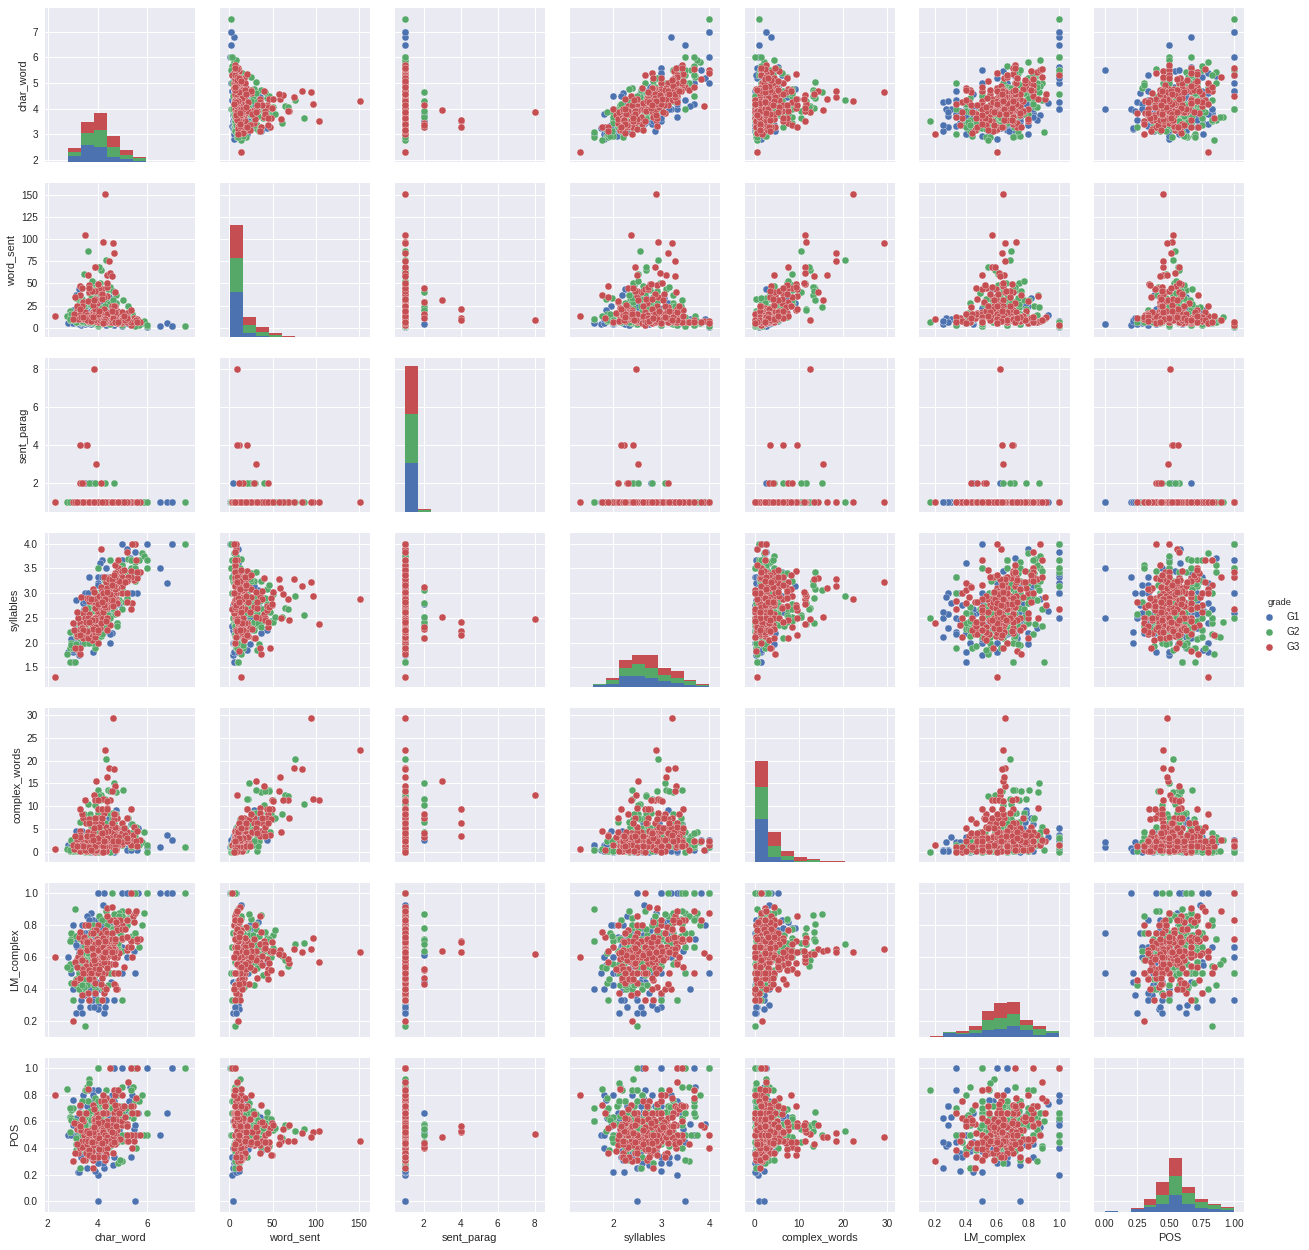

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.pairplot(data=df_traintest, hue='grade')

In [ ]:
from sklearn.model_selection import train_test_split
# Separating the independent variables from dependent variables
x=df_traintest.iloc[:,:-1]
y=df_traintest.iloc[:,len(df_traintest.columns) - 1]
x_train,x_test, y_train, y_test=train_test_split(x,y,test_size=0.20, random_state=0)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=0),
    SVC(gamma=2, C=1, random_state=0),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=0),
    DecisionTreeClassifier(max_depth=5, random_state=0),
    #RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    RandomForestClassifier(n_estimators=1000, random_state=0),
    MLPClassifier(alpha=1, max_iter=1000, random_state=0),
    AdaBoostClassifier(random_state=0),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

# iterate over classifiers
best_acc = 0.0
best_mse = 10000
best_clf = ""
best_clf2 = ""
for name, clf in zip(names, classifiers):
    
    #if name != "Decision Tree":
        #continue
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    clf.fit(x_train, y_train)
    y_pred=clf.predict(x_test)
    print("*" * 50, name, "*" * 50)
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test, y_pred))
    acc = accuracy_score(y_test, y_pred)
    #mse = mean_squared_error(y_test, y_pred)
    print("accuracy = ", acc)

    if best_acc < acc:
        best_acc = acc
        best_clf = name
    #if best_mse > mse:
    #    best_mse = mse
    #    best_clf2 = name

print("Done! best_acc = ", best_acc, "(", best_clf, ")")
#print("Done! best_mse = ", best_mse, "(", best_clf2, ")")

************************************************** Nearest Neighbors **************************************************
[[22  8  4]
 [17 11 10]
 [15 14 19]]
             precision    recall  f1-score   support

         G1       0.41      0.65      0.50        34
         G2       0.33      0.29      0.31        38
         G3       0.58      0.40      0.47        48

avg / total       0.45      0.43      0.43       120

accuracy =  0.43333333333333335
************************************************** Linear SVM **************************************************
[[32  2  0]
 [27  9  2]
 [32 12  4]]
             precision    recall  f1-score   support

         G1       0.35      0.94      0.51        34
         G2       0.39      0.24      0.30        38
         G3       0.67      0.08      0.15        48

avg / total       0.49      0.38      0.30       120

accuracy =  0.375
************************************************** RBF SVM ************************************************